In [3]:
import pandas as pd
import warnings
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML 
# display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
train=pd.read_csv("train_data.csv")
test=pd.read_csv("test_data.csv")
import pandas_profiling as pdp
df=pd.concat([train,test],sort=False)


In [19]:
import pandas_profiling as pdp
def preprocess():
    train=pd.read_csv("train_data.csv")
    test=pd.read_csv("test_data.csv")
    df=pd.concat([train,test],sort=False)
    df.age=df.age.map(lambda x:57 if x>58 else x)
    df.num_child=df.num_child.map(lambda x:7 if x>7 else x)
    df.study_time=df.study_time.map(lambda x:17 if x>17 else x)
    df["familiy_num"]=1+df.partner+df.num_child
    arealist=list(train.groupby("area").mean().salary.sort_values().index)
    areadic={}
    for i,area in enumerate(arealist):
        areadic[area]=i+1
    df.area=df.area.map(areadic)
    df.position=df.position+1
    df.sex=df.sex-1
    df.salary=np.log(df.salary)
    df["agexposition"]=df.age*df.position.map(lambda x:1.5 if x==1 else x)
    df.education=df.education+1
#     df=pd.get_dummies(df,drop_first=True, columns=['position','education'])
#     df.drop(["sex"],axis=1)
    train=df.dropna().drop(["id"],axis=1)
    test=df[df.salary.isnull()].drop(["id"],axis=1)
    test=test.drop(["salary",],axis=1)
    X = train.drop(["salary"],axis=1)
    y = train.salary
    return X,y,test,df
X,y,test,df=preprocess()
#original 23.625521293118492
train=pd.concat([X,y],axis=1)

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
model=lgb.LGBMRegressor(**{'booster': 'gblinear',
                           'iterations': 309, 'depth': 16, 'learning_rate': 0.1,
                           'random_strength': 48, 'bagging_temperature': 19.715729096205934, 
                           'od_type': 'Iter', 'od_wait': 26, 'lambda_l1': 0.726486176355415, 
                           'lambda_l2': 0.00044177449020498015, 'num_leaves': 188,
                           'feature_fraction': 0.9443254919883529, 'bagging_fraction': 0.9271673814820428, 
                           'bagging_freq': 2, 'min_child_samples': 17})
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())

[22.235450246603516, 21.939352391567876, 22.5758178205997, 22.740848425970245, 21.628926730218478]
22.224079122991963


# additional feature

# Learning

In [6]:
X=X.applymap(np.float)

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from deap import algorithms, base, creator, tools, gp
X_train, X_test,y_train, y_test = train_test_split(np.array(X),np.array(y),test_size=0.8,random_state=123)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

[1]	valid_0's l2: 0.168366
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.143661
[3]	valid_0's l2: 0.123262
[4]	valid_0's l2: 0.105956
[5]	valid_0's l2: 0.0918256
[6]	valid_0's l2: 0.0794009
[7]	valid_0's l2: 0.0695068
[8]	valid_0's l2: 0.0613051
[9]	valid_0's l2: 0.0550128
[10]	valid_0's l2: 0.0489397
[11]	valid_0's l2: 0.0443457
[12]	valid_0's l2: 0.0402479
[13]	valid_0's l2: 0.0369653
[14]	valid_0's l2: 0.0341288
[15]	valid_0's l2: 0.0317089
[16]	valid_0's l2: 0.0297169
[17]	valid_0's l2: 0.0278021
[18]	valid_0's l2: 0.0261425
[19]	valid_0's l2: 0.0249164
[20]	valid_0's l2: 0.0236687
[21]	valid_0's l2: 0.0226069
[22]	valid_0's l2: 0.0218491
[23]	valid_0's l2: 0.0210339
[24]	valid_0's l2: 0.0203182
[25]	valid_0's l2: 0.0197036
[26]	valid_0's l2: 0.0192431
[27]	valid_0's l2: 0.0186945
[28]	valid_0's l2: 0.0183283
[29]	valid_0's l2: 0.0179544
[30]	valid_0's l2: 0.0175463
[31]	valid_0's l2: 0.0172912
[32]	valid_0's l2: 0.017136
[33]	valid_0's l2: 0.0169

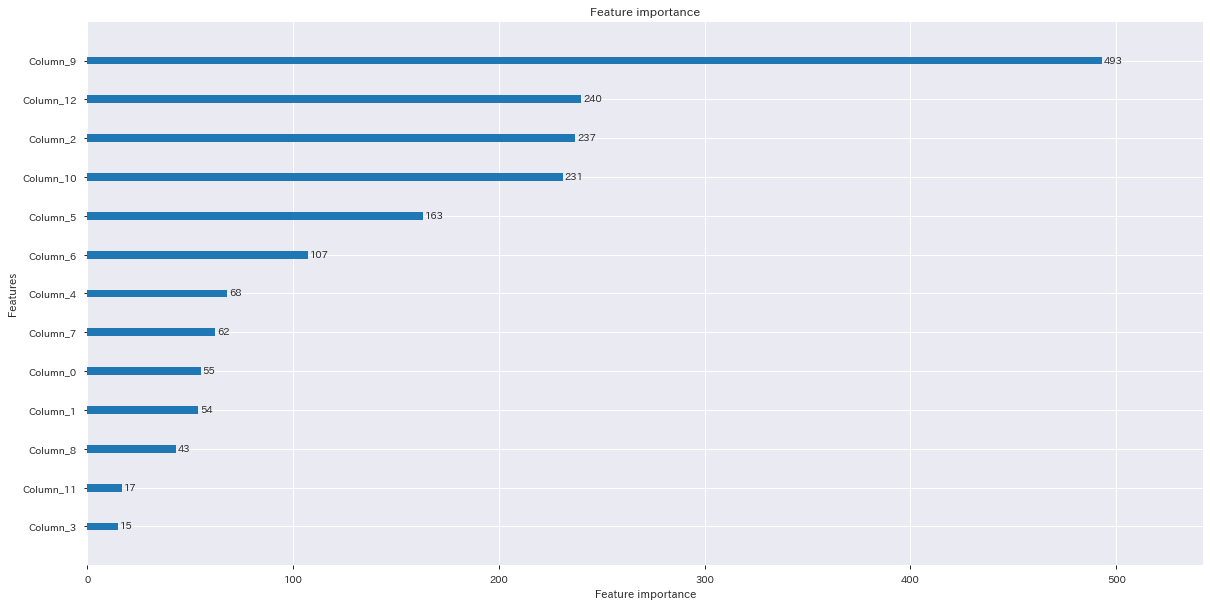

In [8]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train2, y_train2)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'subsample' : 0.8,
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'regression',

    }

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(20, 10))
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score

# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# auc を計算する
mae=mean_absolute_error(np.exp(y_pred),np.exp( y_test))
print(mae)

27.733957083678845


In [10]:

# 除算関数の定義
# 左項 / 右項で右項が0の場合1を代入する
def protectedDiv(left, right):
    eps = 1.0e-7
    tmp = np.zeros(len(left))
    tmp[np.abs(right) >= eps] = left[np.abs(right) >= eps] / right[np.abs(right) >= eps]
    tmp[np.abs(right) < eps] = 1.0
    return tmp

In [11]:
# 乱数シード
import random
random.seed(123)

# 適合度を最大化するような木構造を個体として定義
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [12]:
# 初期値の計算
from sklearn.ensemble import RandomForestRegressor as RFR
def cross_val(model,X,y):
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
#     print(scores)
    return np.array(scores).mean()


# 学習データの5-fold CVのAUCスコアを評価指標の初期値とする
from sklearn.model_selection import train_test_split, cross_val_score
n_features = X_train.shape[1]
# 上記のパラメータでモデルを学習する
model =RFR()
prev_auc = cross_val(model,X_train,y_train)

In [13]:

# メインループ
# resultsに特徴量数、学習データのAUCスコア（5-fold CV）、テストデータのAUCスコアを保持する
# exprsに生成された特徴量の表記を保持する
results = []
exprs = []

In [14]:
from tqdm import tqdm 
import operator,math, random, time
j=0
for i in tqdm(range(100)):
    print(j)
    j+=1
    # 構文木として利用可能な演算の定義
    pset = gp.PrimitiveSet("MAIN", n_features)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(np.cos, 1)
    pset.addPrimitive(np.sin, 1)
    pset.addPrimitive(np.tan, 1)

    # 関数のデフォルト値の設定
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    # 評価関数の設定
    # 新しく生成した変数を元の変数に加えて5-fold CVを求める
    def eval_genfeat(individual):
        func = toolbox.compile(expr=individual)
        features_train = [X_train[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        X_train_tmp = np.c_[X_train, new_feat_train]
        return np.mean(cross_val(model, X_train_tmp, y_train)),

    # 評価、選択、交叉、突然変異の設定
    # 選択はサイズ10のトーナメント方式、交叉は1点交叉、突然変異は深さ2のランダム構文木生成と定義
    toolbox.register("evaluate", eval_genfeat)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    # 構文木の制約の設定
    # 交叉や突然変異で深さ5以上の木ができないようにする
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5)) 

    # 世代ごとの個体とベスト解を保持するクラスの生成
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    # 統計量の表示設定
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # 進化の実行
    # 交叉確率50%、突然変異確率10%、10世代まで進化
    start_time = time.time()
#     print( toolbox, mstats,hof)
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)
    end_time = time.time()

    # ベスト解とAUCの保持
    best_expr = hof[0]
    best_auc = mstats.compile(pop)["fitness"]["max"]

    # 5-fold CVのAUCスコアが前ステップのAUCを超えていた場合
    # 生成変数を学習、テストデータに追加し、ベストAUCを更新する
    if prev_auc > best_auc:
        # 生成変数の追加
        func = toolbox.compile(expr=best_expr)
        features_train = [X_train[:,i] for i in range(n_features)]
        features_test = [X_test[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        new_feat_test = func(*features_test)
        X_train = np.c_[X_train, new_feat_train]
        X_test = np.c_[X_test, new_feat_test]

        ### テストAUCの計算（プロット用）
        model.fit(X_train, y_train)
        train_auc = cross_val(y_train, model.predict_proba(X_train)[:,1])
        test_auc = cross_val(y_test, model.predict_proba(X_test)[:,1])

        # ベストAUCの更新と特徴量数の加算
        prev_auc = best_auc
        n_features += 1

        # 表示と出力用データの保持
        print(n_features, best_auc, train_auc, test_auc, end_time - start_time)
        results.append([n_features, best_auc, train_auc, test_auc])
        exprs.append(best_expr)

        # 変数追加後の特徴量数が30を超えた場合break
        if n_features >= 30:
            break
        print(prev_auc,best_auc)


  0%|          | 0/100 [00:00<?, ?it/s]

0
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min   	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	29.8252	0  	31.0641	28.366	300   	0.349547	4.28667	0  	14 	2  	300   	2.49088
1  	154   	30.1545	1  	31.0641	29.2421	154   	0.370838	4.31667	1  	15 	1  	154   	2.56964
2  	145   	30.345 	2  	31.5826	28.449 	145   	0.493968	4.55333	2  	18 	1  	145   	3.15285
3  	160   	30.45  	3  	31.5826	28.925 	160   	0.612198	7.01667	3  	18 	1  	160   	4.38745
4  	166   	30.6235	4  	32.2731	29.1703	166   	0.718633	11.25  	4  	18 	2  	166   	3.24769
5  	169   	30.8913	5  	34.5372	28.7783	169   	0.96747 	11.96  	5  	20 	1  	169   	2.19509
6  	166   	31.2113	6  	34.5372	28.7871	166   	1.20422 	11.73  	6  	18 	3  	166   	2.40633
7  	152   	31.9626	7  	34.5372	28.5794	152   	1.51475 	13.3167	7

  1%|          | 1/100 [27:40<45:39:47, 1660.48s/it]

10 	153   	33.1823	10 	34.6911	28.5289	153   	1.72638 	15.3167	10 	22 	1  	153   	2.49461
1
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min   	nevals	std     	avg 	gen	max	min	nevals	std    
0  	300   	29.8129	0  	31.0965	27.609	300   	0.362879	3.82	0  	14 	2  	300   	2.33686
1  	149   	30.1457	1  	31.8663	29.2014	149   	0.377917	4.10333	1  	14 	1  	149   	2.5125 
2  	179   	30.3308	2  	32.362 	28.7986	179   	0.571123	4.72333	2  	12 	1  	179   	2.40003
3  	182   	30.7906	3  	33.9955	27.9672	182   	0.842117	5.91667	3  	14 	1  	182   	2.15168
4  	165   	31.4844	4  	34.2308	29.0898	165   	1.13617 	6.95333	4  	18 	1  	165   	2.6928 
5  	174   	32.0746	5  	34.5987	29.1984	174   	1.41503 	9.06333	5  	18 	3  	174   	4.11655
6  	149   	32.8995	6  	34.6089	28.8229	149   	1.60963 	12.8633	6  	25 

  2%|▏         | 2/100 [1:00:47<47:51:54, 1758.31s/it]

10 	158   	33.3517	10 	34.9122	29.1877	158   	1.77671 	13.6433	10 	25 	1  	158   	2.83951
2
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	29.8152	0  	31.0661	28.0506	300   	0.359914	4.07667	0  	14 	2  	300   	2.51611
1  	163   	30.1291	1  	32.1593	27.9265	163   	0.449253	4.04   	1  	16 	1  	163   	2.67178
2  	174   	30.3093	2  	32.4045	29.0973	174   	0.617073	5.61667	2  	16 	1  	174   	3.46743
3  	145   	30.7482	3  	32.7219	28.415 	145   	0.830558	8.55   	3  	18 	2  	145   	4.30048
4  	147   	31.5166	4  	33.2389	28.8211	147   	1.0378  	7.87333	4  	18 	1  	147   	2.90585
5  	177   	31.8307	5  	33.7472	29.2251	177   	1.14956 	9.32   	5  	19 	2  	177   	2.35321
6  	172   	32.1456	6  	35.3141	29.1413	172   	1.21473 	9.96   

  3%|▎         | 3/100 [1:34:29<49:30:46, 1837.59s/it]

10 	174   	33.9462	10 	36.1155	29.4039	174   	2.01106 	13.41  	10 	22 	1  	174   	2.83817
3
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg 	gen	max	min	nevals	std    
0  	300   	29.8158	0  	31.3122	28.3207	300   	0.355655	3.84	0  	14 	2  	300   	2.24672
1  	180   	30.0815	1  	31.8829	28.9745	180   	0.422505	4.64	1  	14 	1  	180   	3.00839
2  	170   	30.2741	2  	31.8829	28.9608	170   	0.523777	6.57333	2  	18 	1  	170   	4.5707 
3  	174   	30.4391	3  	31.8829	28.672 	174   	0.621642	7.71333	3  	19 	1  	174   	4.69303
4  	145   	30.6615	4  	31.8829	28.5361	145   	0.886157	5.70667	4  	15 	1  	145   	3.91586
5  	161   	30.8384	5  	31.8829	28.1206	161   	1.06555 	3.95   	5  	11 	1  	161   	0.956121
6  	167   	30.7979	6  	31.9305	27.7063	167   	1.15758 	4.01   	6  	10 

  4%|▍         | 4/100 [2:09:46<51:14:09, 1921.35s/it]

10 	152   	31.0207	10 	31.9305	28.1284	152   	1.05083 	4.07   	10 	10 	1  	152   	0.79902 
4
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max   	min    	nevals	std     	avg 	gen	max	min	nevals	std    
0  	300   	29.851	0  	31.209	28.1094	300   	0.378314	3.97	0  	14 	2  	300   	2.41849
1  	178   	30.0872	1  	31.5131	28.9646	178   	0.427349	4.54333	1  	18 	1  	178   	2.7943 
2  	157   	30.2764	2  	31.5131	28.4276	157   	0.539713	4.9    	2  	15 	1  	157   	2.80891
3  	172   	30.4931	3  	31.5131	27.6617	172   	0.663204	5      	3  	16 	1  	172   	2.30796
4  	182   	30.5491	4  	31.7374	28.9856	182   	0.780185	5.03333	4  	16 	1  	182   	2.19216
5  	170   	30.7118	5  	31.9958	27.9781	170   	0.873569	4.33333	5  	16 	1  	170   	1.67597
6  	171   	30.7994	6  	31.9958	28.7278	171   	0.848533	4.07   	6  	8  	

  5%|▌         | 5/100 [2:51:29<55:18:13, 2095.72s/it]

10 	161   	30.9566	10 	31.9958	29.0632	161   	1.07075 	4.06   	10 	9  	1  	161   	0.763588
5
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	29.8477	0  	32.0837	28.6293	300   	0.372849	4.32667	0  	15 	2  	300   	2.68948
1  	163   	30.1411	1  	32.7644	28.2497	163   	0.548469	4.64333	1  	11 	2  	163   	2.21422
2  	158   	30.5254	2  	33.4836	29.0451	158   	0.853931	4.86   	2  	15 	1  	158   	1.96987
3  	157   	31.252 	3  	33.7566	27.5835	157   	1.31494 	5.21667	3  	13 	1  	157   	1.8211 
4  	161   	32.055 	4  	33.9976	29.3622	161   	1.35538 	5.65   	4  	14 	1  	161   	1.62301
5  	159   	32.2485	5  	34.4744	29.1273	159   	1.59505 	5.42667	5  	14 	1  	159   	1.73914
6  	164   	32.3432	6  	34.4744	28.7224	164   	1.68317 	6.23  

  6%|▌         | 6/100 [3:31:34<57:08:51, 2188.63s/it]

10 	166   	32.7926	10 	34.6154	28.6726	166   	1.97881 	6.91667	10 	13 	1  	166   	1.6542 
6
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	29.8278	0  	31.5756	27.8913	300   	0.355288	4.26667	0  	14 	2  	300   	2.69732
1  	153   	30.1075	1  	31.5756	28.9431	153   	0.46044 	4.90333	1  	17 	1  	153   	3.19802
2  	169   	30.2924	2  	31.6545	27.9182	169   	0.593011	5.17333	2  	18 	1  	169   	3.20156
3  	165   	30.592 	3  	31.8108	28.9111	165   	0.756089	4.07   	3  	14 	1  	165   	2.28439
4  	175   	30.7659	4  	31.8212	28.7714	175   	0.885713	3.19333	4  	12 	1  	175   	1.08748
5  	172   	30.9175	5  	31.8212	29.0071	172   	0.880849	3.08333	5  	7  	1  	172   	0.574214
6  	162   	30.9514	6  	31.892 	28.9396	162   	0.941068	3.0766

  7%|▋         | 7/100 [4:27:23<65:32:09, 2536.87s/it]

10 	174   	30.9927	10 	32.0828	28.9933	174   	1.04104 	3.18333	10 	9  	1  	174   	0.932589
7
   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	29.8386	0  	31.5038	28.0738	300   	0.35881	4.08667	0  	15 	2  	300   	2.44796
1  	173   	30.1285	1  	31.7329	28.0673	173   	0.440859	4.79   	1  	14 	1  	173   	2.404  
2  	169   	30.3023	2  	31.7329	29.0563	169   	0.598221	4.34667	2  	11 	1  	169   	1.61033
3  	166   	30.6457	3  	32.4044	29.099 	166   	0.796634	4.36667	3  	11 	1  	166   	1.43256
4  	158   	31.0042	4  	32.4044	28.9562	158   	0.904466	4.44667	4  	8  	1  	158   	0.990196
5  	154   	31.1499	5  	33.0436	28.909 	154   	1.06035 	4.88   	5  	11 	1  	154   	1.27499 
6  	160   	31.4075	6  	33.0436	28.6588	160   	1.16629 	5.30333	

  8%|▊         | 8/100 [5:00:54<60:47:40, 2378.92s/it]

10 	184   	31.9934	10 	33.4656	28.9825	184   	1.41663 	5.10667	10 	10 	1  	184   	1.28917 
8
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	29.8429	0  	31.0564	27.9774	300   	0.382578	4.20333	0  	15 	2  	300   	2.48234
1  	148   	30.1688	1  	31.0564	27.9234	148   	0.393931	4.64333	1  	15 	1  	148   	2.6146 
2  	169   	30.2686	2  	31.5313	28.3423	169   	0.551622	4.64   	2  	19 	1  	169   	2.44889
3  	162   	30.472 	3  	31.5313	28.9031	162   	0.616192	4.62   	3  	15 	1  	162   	2.01385
4  	156   	30.6601	4  	34.0132	28.9131	156   	0.725889	4.82667	4  	12 	1  	156   	1.733  
5  	170   	30.9196	5  	34.1129	28.9047	170   	1.0586  	6.10667	5  	13 	1  	170   	1.34237
6  	174   	31.6379	6  	34.6181	28.9982	174   	1.61505 	7.0466

  9%|▉         | 9/100 [5:42:53<61:11:57, 2421.07s/it]

10 	147   	32.8919	10 	34.6181	29.0821	147   	2.08009 	8.47333	10 	16 	1  	147   	2.07909
9
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	29.8421	0  	31.3176	28.0122	300   	0.352749	4.50333	0  	15 	2  	300   	2.91261
1  	178   	30.1058	1  	31.3176	29.0176	178   	0.393364	4.96667	1  	15 	1  	178   	3.15683
2  	184   	30.2298	2  	31.7726	27.9303	184   	0.585315	4.86   	2  	16 	1  	184   	2.85197
3  	186   	30.6356	3  	31.9307	28.8027	186   	0.778697	4.11333	3  	15 	1  	186   	2.29648
4  	154   	30.9269	4  	32.1507	28.9009	154   	0.91821 	3.95667	4  	13 	2  	154   	1.75351
5  	165   	31.0139	5  	32.1507	28.8721	165   	0.959977	3.98   	5  	9  	2  	165   	1.70086
6  	159   	31.0488	6  	32.1507	28.7663	159   	1.03602 	4.17   

 10%|█         | 10/100 [6:25:29<61:32:25, 2461.62s/it]

10 	179   	31.1172	10 	32.2405	28.9601	179   	1.07701 	7.56667	10 	13 	1  	179   	1.7375 
10
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg 	gen	max	min	nevals	std    
0  	300   	29.8135	0  	30.8193	28.8952	300   	0.334345	3.96	0  	14 	2  	300   	2.46274
1  	165   	30.1106	1  	32.6009	28.8002	165   	0.384439	4.96	1  	17 	1  	165   	3.31337
2  	155   	30.2815	2  	32.8547	28.9988	155   	0.540287	5.86333	2  	16 	1  	155   	3.68755
3  	164   	30.5042	3  	33.001 	28.9366	164   	0.77467 	8.65   	3  	17 	1  	164   	3.34278
4  	171   	31.2384	4  	33.8967	28.4293	171   	1.18248 	8.68667	4  	16 	1  	171   	2.49035
5  	164   	31.7258	5  	33.8967	28.2636	164   	1.33767 	9.21333	5  	18 	1  	164   	2.73639
6  	180   	31.8171	6  	33.8967	29.2965	180   	1.47484 	9.72333	6  	20 

 11%|█         | 11/100 [7:12:38<63:34:52, 2571.83s/it]

10 	163   	32.5909	10 	34.1313	28.8893	163   	1.64828 	11.6033	10 	17 	3  	163   	2.09904
11
   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min    	nevals	std     	avg    	gen	max	min	nevals	std    
0  	300   	29.8225	0  	31.207	27.6816	300   	0.393946	4.16333	0  	14 	2  	300   	2.41592
1  	158   	30.1511	1  	31.8623	28.0402	158   	0.436335	5.04333	1  	16 	1  	158   	2.56414
2  	176   	30.3045	2  	32.0112	28.7097	176   	0.604046	4.71   	2  	12 	1  	176   	2.35214
3  	161   	30.6326	3  	32.0112	28.9987	161   	0.814162	3.56667	3  	10 	1  	161   	1.62447
4  	177   	30.8643	4  	32.0112	28.8923	177   	0.943793	3.04333	4  	7  	1  	177   	0.566971


KeyboardInterrupt: 

In [ ]:
# 生成した構文木の出力
print()
print("### Generated feature expression")
for expr in exprs:
    print(expr)

In [ ]:
np.array(X)

In [15]:
from sklearn.ensemble import RandomForestRegressor as RFR
import numpy as np
from sklearn.metrics import mean_absolute_error

rg = RFR(n_jobs=-1, random_state=2525)
 
rg.fit(train_X,train_y)
print(rg.score(valid_X,valid_y))
from sklearn.metrics import mean_squared_error
score=mean_absolute_error(np.exp(valid_y),np.exp(rg.predict(valid_X)))
print(f'MAE:{score:4f}')
fti = rg.feature_importances_

print('Feature Importances:')
for i,feat in enumerate(valid_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))
col_names = test.columns.values
col_names_ = col_names[np.argsort(rg.feature_importances_)[::-1]]
col_names_

NameError: name 'train_X' is not defined

In [16]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
model=lgb.LGBMRegressor()
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())
#noadditional 23.625521293118492
#

[22.764094288724273, 22.792014845341466, 23.487210364564227, 23.352820410841307, 22.616116417087895]
23.00245126531183


# ModelSelection

In [ ]:
# 特徴量を選択して、複数のモデルで精度を調査する
from scipy.stats import mstats
from tqdm import tqdm
import matplotlib
from sklearn import metrics,  feature_selection, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
# from imblearn import under_sampling, over_sampling
from sklearn.metrics import  mean_squared_error
from sklearn.metrics import make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
base_color = 'darkturquoise'
base_color2 = 'gray'

def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)
cm = generate_cmap([base_color2, 'white', base_color])

def rmse_score(y_true, y_pred):
    """RMSE (Root Mean Square Error: 平均二乗誤差平方根) を計算する関数"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

params={'booster': 'dart', 
        'alpha': 0.009385870161072372, 
        'max_depth': 9, 'eta': 2.3698818355249718e-07,
        'gamma': 3.167530221746867e-05, 
        'grow_policy': 'lossguide',
        'sample_type': 'weighted',
        'normalize_type': 'forest',
        'rate_drop': 3.1207262366715483e-08,
        'skip_drop': 1.2650261386504368e-05}


models = [
 
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
 
    #Gaussian Processes
#     gaussian_process.GaussianProcessRegressor(),
    
    #GLM
    linear_model.Ridge(),

    
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
 
    #xgboost
    xgb. XGBRegressor(),
    lgb.LGBMRegressor(),
#     cat.CatBoostRegressor(),
    
]
 
df_compare = pd.DataFrame(columns=['name', 'train_rmse', 'valid_rmse', 'time'])
score_funcs = {
    'rmse': make_scorer(rmse_score),
}

for model in tqdm(models):
    
    name = model.__class__.__name__
    
    cv_rlts = model_selection.cross_validate(model,X,y, scoring=score_funcs, cv=10, return_train_score=True)
 
    for i in range(10):
        s = pd.Series([name, cv_rlts['train_rmse'][i], cv_rlts['test_rmse'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name=name+str(i))
        df_compare = df_compare.append(s)
        
plt.figure(figsize=(12,8))
sns.boxplot(data=df_compare, y='name', x='valid_rmse', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

In [ ]:
cols = X.columns.tolist()
 
# positive_cnt = int(df['salary'].sum())

feature_importance_models = [
    ensemble.AdaBoostRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    tree.DecisionTreeRegressor(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
]
 
scoring = ['rsme']
df_rfe_cols_cnt = pd.DataFrame(columns=['cnt'], index=cols)
df_rfe_cols_cnt['cnt'] = 0
 
for i, model in tqdm(enumerate(feature_importance_models), total=len(feature_importance_models)):
    
    rfe = feature_selection.RFECV(model, step=3)
    rfe.fit(X, y)
#     print(rfe.get_support())
    rfe_cols = X[cols].columns.values[rfe.get_support()]
    df_rfe_cols_cnt.loc[rfe_cols, 'cnt'] += 1
    
df_rfe_cols_cnt.plot(kind='bar', color=base_color, figsize=(15, 5))
plt.show()

In [ ]:
x_cols = df_rfe_cols_cnt[df_rfe_cols_cnt['cnt'] < 4].index
X=X.drop(x_cols,axis=1)
test=test.drop(x_cols,axis=1)
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [ ]:
# cat_list = ['area', 'sex', 'partner','education']

## XGBoost+optuna

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import r2_score

class RidgeCV():
    model_cls = Ridge

    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
        elif isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
            y = y.reset_index(drop=True)

        self.X = X
        self.y = y

        study = optuna.create_study(direction='maximize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        self.best_model = self.model_cls(**self.best_trial.params)
        self.best_model.fit(self.X, self.y)

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X.values.reshape(1, -1))
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        return self.best_model.predict(X)

    def score(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)

        return self.best_model.score(X, y)

    def kfold_cv(self, model, splits=5):
        scores = []

        kf = KFold(n_splits=splits, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(r2_score(model.predict(X_test), y_test))

        score = np.array(scores).mean()
        return score

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

class XGBRegressorCV(RidgeCV):
    model_cls = xgb.XGBRegressor

    def __call__(self, trial):
        booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
        alpha = trial.suggest_loguniform('alpha', 1e-8, 1.0)

        max_depth = trial.suggest_int('max_depth', 1, 20)
        eta = trial.suggest_loguniform('eta', 1e-8, 1.0)
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        grow_policy = trial.suggest_categorical(
            'grow_policy', ['depthwise', 'lossguide'])

        if booster == 'gbtree':
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy)
        elif booster == 'dart':
            sample_type = trial.suggest_categorical('sample_type',
                                                    ['uniform', 'weighted'])
            normalize_type = trial.suggest_categorical('normalize_type',
                                                       ['tree', 'forest'])
            rate_drop = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
            skip_drop = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,
                                   sample_type=sample_type,
                                   normalize_type=normalize_type,
                                   rate_drop=rate_drop, skip_drop=skip_drop)

        score = self.kfold_cv(model)
        return score

xgbr = XGBRegressorCV(n_trials=100)
# xgbr.fit(train_X, train_y)

# pred_y=xgbr.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(xgbr.predict(valid_X)))
# print(f'MAE:{score:4f}')
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=3, shuffle=True, random_state=0)
model = XGBRegressorCV(n_trials=10)
scores = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())
#MAE:22.821581(drop)dummy
#MAE:22.753628(nodrop)dummy

# LightGBM+optuna

In [ ]:
# coding:utf-8
import lightgbm as lgb
# from sklearn.metrics import log_loss
def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / ( x_max - x_min)
    return x_norm
def min_max_renormalization(x1,x2):
    x_min = x2.min()
    x_max = x2.max()
#     x_norm = (x2 - x_min) / ( x_max - x_min)
    x=x1*  ( x_max - x_min)+x_min
    return x

import lightgbm as lgb
# from sklearn.metrics import log_loss
cat_list = ['area', 'sex', 'partner','education']
class LGBRegressorCV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'eval_metric':'mae',
            'booster':trial.suggest_categorical('booster',['gbtree','gblinear']),
            'loss_function': 'fair',
            'iterations' : trial.suggest_int('iterations', 50, 400),                      
#             'depth' : trial.suggest_int('depth', 4, 25),  
            'depth':16,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50),
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressorCV(n_trials=20)
kf = KFold(n_splits=3, shuffle=True, random_state=0)
# model = XGBRegressorCV(n_trials=20)
scores = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())
# checktesty=valid_y.sort_values()
# checktestX=valid_X.ix[list(checktesty.index)]
# checktesty=checktesty.reset_index(drop=True)#これと

# checkpred=pd.DataFrame(model.predict(checktestX))#これ
# check=pd.concat([checktesty,checkpred], axis=1)
# check.columns=["actual","predict"]
# check.plot(alpha=0.5)
#MAE:23.144563 (nodrop)dummy
#MAE:23.742147(drop)dummy
#MAE:23.902507nodummy

In [ ]:
    
class LGBRegressor1CV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'loss_function': 'xentropy loss',
            'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 8, 20), 
#             'depth':16,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressor1CV(n_trials=40)
train_ylgm=min_max_normalization(train_y)
model.fit(train_X,train_ylgm)

pred_y=min_max_renormalization(model.predict(valid_X),train_y)
score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
print(f'MAE:{score:4f}')
pred=model.predict(test)


In [ ]:
class LGBRegressor2CV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            
            'loss_function': 'regression_l1',
            'iterations' : trial.suggest_int('iterations', 50, 400),                      
            'depth' : trial.suggest_int('depth', 4, 25),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressor2CV(n_trials=40)
model.fit(train_X,train_y)

pred_y=model.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
print(f'MAE:{score:4f}')

## CatBoost+optuna(non recomended)

In [ ]:
from catboost import CatBoost
# from sklearn.metrics import log_loss

class CatRegressorCV(RidgeCV):
    model_cls = CatBoost
    def __call__(self, trial):
        params = {
            'loss_function': 'MAE',
#             'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 6, 10),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(params)
        score = self.kfold_cv(model)
        return score
# model=CatRegressorCV(n_trials=10)
model=CatBoost({'depth': 7, 'learning_rate': 0.074638569770399, 'random_strength': 59, 'bagging_temperature': 0.011038111194790014, 'od_type': 'IncToDec', 'od_wait': 12})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
model.fit(train_X,train_y)

pred_y=model.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
print(f'MAE:{score:4f}')
pred=model.predict(test)

## Data engeneering for NN

In [404]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
categorical_variable_names = ["position","sex","education"]
# カテゴリ変数に一括変換
# x_dummy = pd.get_dummies(df[categorical_variable_names], drop_first=True,columns=categorical_variable_names)
# X_nn=df.drop(categorical_variable_names, axis=1)
X_nn=df
sscaler =StandardScaler()
sscaler.fit(X_nn)  

x_datas_std =sscaler.transform(X_nn)
x_datas_std = pd.DataFrame(x_datas_std, columns=X_nn.columns)
X_nn= pd.concat([x_datas_std,], axis=1)


train_X_nn=X_nn.drop("id",axis=1)
test_nn=X_nn[X_nn.salary.isnull()].drop("id",axis=1)
test_nn= test_nn.drop(["salary",],axis=1)
train_X_nn= train_X_nn.dropna().drop(["salary"],axis=1)

In [405]:
train_X_nn

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,familiy_num,agexposition
0,-0.176420,1.027084,1.544468,1.009041,0.998734,0.708483,-0.085928,1.097992,-0.537098,0.818742,-0.243349,0.832908,-0.008975
1,0.643375,-0.192567,0.292875,-0.991040,-1.001267,-0.708058,-0.982563,0.069682,1.584501,-0.539406,0.283116,-0.833279,0.070094
2,0.643375,0.276529,0.145629,-0.991040,-1.001267,-0.708058,0.810708,0.163165,0.069073,-0.992122,1.023458,-0.833279,0.307300
3,-0.996214,-1.036941,1.691715,1.009041,-1.001267,-0.708058,-0.982563,-0.771663,-0.234012,-0.992122,-0.753363,-0.833279,-0.878731
4,-0.996214,-0.755483,-0.737849,1.009041,-1.001267,-0.708058,-0.085928,-0.678180,-0.234012,-1.293932,-0.950787,-0.833279,-0.807569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-0.996214,-0.567845,-0.516979,1.009041,-1.001267,-0.708058,-0.085928,-0.491214,-0.537098,-1.293932,0.793129,-0.833279,-0.760128
20996,-0.996214,-1.036941,1.470845,1.009041,-1.001267,-0.708058,-0.982563,-0.771663,-0.234012,-1.293932,0.447636,-0.833279,-0.878731
20997,1.463169,0.276529,1.249976,1.009041,-1.001267,-0.708058,0.810708,0.163165,0.069073,-0.388501,0.332472,-0.833279,0.876595
20998,-0.996214,-1.130761,0.808237,1.009041,0.998734,0.708483,-0.085928,-1.145594,-0.840184,-0.086690,0.036335,0.832908,-0.902451


In [406]:
#ニューラルネットワークモデルの生成
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(800, activation = 'relu'))
model.add(Dense(100, activation =  'relu'))
model.add(Dense(1))
# モデルをコンパイル 
from keras.optimizers import Adam
# ylgm=min_max_normalization(y)
train_X_nn, valid_X_nn,train_y_nn, valid_y_nn = train_test_split(train_X_nn,y,test_size=0.2,random_state=43)

model.compile(Adam(lr=1e-3), loss="mean_squared_error")
#トレーニングデータで学習し，テストデータで評価（平均2乗誤差を用いる）
history = model.fit(np.array(train_X_nn), np.array(train_y_nn), batch_size=128, epochs=100, verbose=1, 
          validation_data=(np.array(valid_X_nn), np.array(valid_y_nn)))

Train on 16800 samples, validate on 4200 samples
Epoch 1/100
16800/16800 [==============================] - ETA: 31s - loss: 32.925 - ETA: 13s - loss: 24.315 - ETA: 9s - loss: 16.529 - ETA: 6s - loss: 12.08 - ETA: 5s - loss: 9.5510 - ETA: 4s - loss: 7.818 - ETA: 4s - loss: 6.887 - ETA: 3s - loss: 6.059 - ETA: 3s - loss: 5.394 - ETA: 3s - loss: 4.912 - ETA: 3s - loss: 4.621 - ETA: 3s - loss: 4.368 - ETA: 2s - loss: 4.060 - ETA: 2s - loss: 3.879 - ETA: 2s - loss: 3.705 - ETA: 2s - loss: 3.481 - ETA: 2s - loss: 3.279 - ETA: 2s - loss: 3.098 - ETA: 2s - loss: 2.938 - ETA: 2s - loss: 2.839 - ETA: 2s - loss: 2.749 - ETA: 2s - loss: 2.664 - ETA: 2s - loss: 2.587 - ETA: 2s - loss: 2.509 - ETA: 2s - loss: 2.438 - ETA: 1s - loss: 2.339 - ETA: 1s - loss: 2.276 - ETA: 1s - loss: 2.218 - ETA: 1s - loss: 2.162 - ETA: 1s - loss: 2.109 - ETA: 1s - loss: 2.035 - ETA: 1s - loss: 1.989 - ETA: 1s - loss: 1.924 - ETA: 1s - loss: 1.882 - ETA: 1s - loss: 1.823 - ETA: 1s - loss: 1.785 - ETA: 1s - loss: 1.749 

16800/16800 [==============================] - ETA: 3s - loss: 0.020 - ETA: 7s - loss: 0.015 - ETA: 8s - loss: 0.019 - ETA: 5s - loss: 0.019 - ETA: 4s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.016 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.014 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.007 - ETA: 7s - loss: 0.007 - ETA: 6s - loss: 0.008 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.006 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0

4200/4200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 138us/step
0.009095980622583912


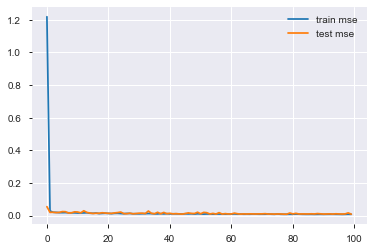

In [407]:
#結果の表示
import matplotlib.pyplot as plt #プロット用のライブラリを利用

print(model.evaluate(valid_X_nn, valid_y_nn))

train_acc = history.history['loss']
test_acc = history.history['val_loss']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mse')
plt.plot(x, test_acc, label = 'test mse')
plt.legend() #グラフの線の説明を表示

In [408]:
pred_y=model.predict(valid_X_nn)
score=mean_absolute_error(np.exp(valid_y_nn),np.exp(pred_y))
print(f'MAE:{score:4f}')
pred=model.predict(test_nn)


MAE:25.749117


,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,familiy_num,agexposition,cluster
0,4,39,14,1,1,5,2,19,1.0,1.8,14.2,7,156.0,19
1,2,31,27,0,0,0,5,0,0.0,0.5,18.6,1,62.0,0
2,1,20,45,1,1,2,1,2,2.0,1.2,2.3,4,30.0,14
3,1,28,37,1,0,0,1,10,3.0,0.3,0.0,1,42.0,9
4,2,41,16,1,0,0,1,23,3.0,0.5,10.1,1,82.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,2,43,14,1,0,0,1,25,3.0,0.7,0.0,1,86.0,4
8996,3,40,5,1,0,0,1,22,8.0,0.7,5.7,1,120.0,7
8997,5,46,24,0,0,0,1,28,2.0,0.8,0.0,1,230.0,17
8998,1,22,13,0,0,0,1,4,0.0,0.1,0.7,1,33.0,12


# Stacking

In [410]:
import numpy as np
import pandas as pd
from catboost import CatBoost
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
# tensorflowの警告抑制
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd


# ---------------------------------
# スタッキング
# ----------------------------------
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

# models.pyにModel1Xgb, Model1NN, Model2Linearを定義しているものとする
# 各クラスは、fitで学習し、predictで予測値の確率を出力する


# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test


# 1層目のモデル

model_1a =xgb.XGBRegressor(**{'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06})
pred_train_1a, pred_test_1a = predict_cv(model_1a, X, y, test)

model_1b = lgb.LGBMRegressor(**{'iterations': 55, 'depth': 22, 'learning_rate': 0.15022735769525583, 'random_strength': 40, 'bagging_temperature': 0.03207087240546606, 'od_type': 'Iter', 'od_wait': 41})
pred_train_1b, pred_test_1b = predict_cv(model_1b, X, y, test)

model_1c = LGBRegressorCV(n_trials=10)
pred_train_1c, pred_test_1c = predict_cv(model_1c, X, y, test)

model_1d = RFR(n_jobs=-1, random_state=2525)
pred_train_1d, pred_test_1d = predict_cv(model_1d, X, y, test)

model_1e =  CatBoost()
pred_train_1e, pred_test_1e = predict_cv(model_1e, X, y, test)

# model_1f=

# 1層目のモデルの評価
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1a))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1b))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1c))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1d))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1e))}')

# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b,'pred_1c': pred_train_1c,'pred_1d': pred_train_1d,'pred_1e': pred_train_1e})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b, 'pred_1c': pred_test_1c, 'pred_1d': pred_test_1d, 'pred_1e': pred_test_1e})


# 2層目のモデル
# pred_train_2は、2層目のモデルの学習データのクロスバリデーションでの予測値
# pred_test_2は、2層目のモデルのテストデータの予測値
model_2 = XGBRegressorCV(n_trials=20)
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, y, test_x_2)

print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2))}')
model_2b = lgb.LGBMRegressor()
pred_train_2b, pred_test_2b = predict_cv(model_2b, train_x_2, y, test_x_2)
train_x_3 = pd.DataFrame({'pred_2a': pred_train_2a, 'pred_2b': pred_train_2b})
test_x_3 = pd.DataFrame({'pred_2a': pred_test_2a, 'pred_2b': pred_test_2b})

print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2a))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2b))}')

[14:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 14:18:30,045] Finished trial#0 resulted in value: 0.6043565819234415. Current best value is 0.6043565819234415 with parameters: {'booster': 'gblinear', 'iterations': 122, 'depth': 20, 'learning_rate': 0.011708411691531534, 'random_strength': 43, 'bagging_temperature': 24.461831978594116, 'od_type': 'Iter', 'od_wait': 47, 'lambda_l1': 0.0003256224275922188, 'lambda_l2': 4.238936922941192e-05, 'num_leaves': 43, 'feature_fraction': 0.7707248327545355, 'bagging_fraction': 0.8906911477099924, 'bagging_freq': 2, 'min_child_samples': 88}.
[I 2019-11-20 14:18:32,208] Finished trial#1 resulted in value: 0.9415110780513425. Current best value is 0.9415110780513425 with parameters: {'booster': 'gbtree', 'iterations': 63, 'depth': 9, 'learning_rate': 0.032220248836418316, 'random_strength': 70, 'bagging_temperature': 21.15100928817564, 'od_type': 'Iter', 'od_wait': 17, 'lambda_l1': 0.2958777513373701, 'lambda_l2': 1.0311880248242327e-07, 'num_leaves': 63, 'feature_fraction': 0.722417


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 102, 'depth': 24, 'learning_rate': 0.07564483141599862, 'random_strength': 34, 'bagging_temperature': 0.010013033889029407, 'od_type': 'IncToDec', 'od_wait': 40, 'lambda_l1': 2.436670462541337e-08, 'lambda_l2': 3.3298068705485434e-07, 'num_leaves': 185, 'feature_fraction': 0.6542427094364054, 'bagging_fraction': 0.7734891236667175, 'bagging_freq': 4, 'min_child_samples': 33}



[I 2019-11-20 14:18:59,299] Finished trial#0 resulted in value: 0.956099778308922. Current best value is 0.956099778308922 with parameters: {'booster': 'gblinear', 'iterations': 157, 'depth': 13, 'learning_rate': 0.1842567962272112, 'random_strength': 4, 'bagging_temperature': 10.723387215185724, 'od_type': 'Iter', 'od_wait': 25, 'lambda_l1': 2.905608158726086e-06, 'lambda_l2': 4.313764658300423e-06, 'num_leaves': 32, 'feature_fraction': 0.8474055963151101, 'bagging_fraction': 0.7091896738287273, 'bagging_freq': 5, 'min_child_samples': 17}.
[I 2019-11-20 14:19:01,342] Finished trial#1 resulted in value: 0.938048402195524. Current best value is 0.956099778308922 with parameters: {'booster': 'gblinear', 'iterations': 157, 'depth': 13, 'learning_rate': 0.1842567962272112, 'random_strength': 4, 'bagging_temperature': 10.723387215185724, 'od_type': 'Iter', 'od_wait': 25, 'lambda_l1': 2.905608158726086e-06, 'lambda_l2': 4.313764658300423e-06, 'num_leaves': 32, 'feature_fraction': 0.847405596


Best score: 0.96
Best params: {'booster': 'gblinear', 'iterations': 157, 'depth': 13, 'learning_rate': 0.1842567962272112, 'random_strength': 4, 'bagging_temperature': 10.723387215185724, 'od_type': 'Iter', 'od_wait': 25, 'lambda_l1': 2.905608158726086e-06, 'lambda_l2': 4.313764658300423e-06, 'num_leaves': 32, 'feature_fraction': 0.8474055963151101, 'bagging_fraction': 0.7091896738287273, 'bagging_freq': 5, 'min_child_samples': 17}



[I 2019-11-20 14:19:23,115] Finished trial#0 resulted in value: 0.9425957163349349. Current best value is 0.9425957163349349 with parameters: {'booster': 'gbtree', 'iterations': 174, 'depth': 14, 'learning_rate': 0.5421405403866358, 'random_strength': 80, 'bagging_temperature': 0.04017628837898865, 'od_type': 'IncToDec', 'od_wait': 22, 'lambda_l1': 3.452892041612629e-08, 'lambda_l2': 0.00014667709942794993, 'num_leaves': 103, 'feature_fraction': 0.9507822358048381, 'bagging_fraction': 0.6487603668695829, 'bagging_freq': 6, 'min_child_samples': 90}.
[I 2019-11-20 14:19:24,625] Finished trial#1 resulted in value: 0.9495955420462524. Current best value is 0.9495955420462524 with parameters: {'booster': 'gbtree', 'iterations': 246, 'depth': 19, 'learning_rate': 0.3259652196348137, 'random_strength': 13, 'bagging_temperature': 0.34173796237011045, 'od_type': 'IncToDec', 'od_wait': 35, 'lambda_l1': 3.4039322856281136e-07, 'lambda_l2': 0.026138284414901847, 'num_leaves': 25, 'feature_fraction


Best score: 0.95
Best params: {'booster': 'gbtree', 'iterations': 306, 'depth': 19, 'learning_rate': 0.25694387506947475, 'random_strength': 99, 'bagging_temperature': 0.039897530190058386, 'od_type': 'Iter', 'od_wait': 32, 'lambda_l1': 0.004267031874016318, 'lambda_l2': 2.6469306427132437, 'num_leaves': 147, 'feature_fraction': 0.8673456624254294, 'bagging_fraction': 0.9387013838286312, 'bagging_freq': 2, 'min_child_samples': 88}



[I 2019-11-20 14:19:49,342] Finished trial#0 resulted in value: 0.9436375317909936. Current best value is 0.9436375317909936 with parameters: {'booster': 'gbtree', 'iterations': 140, 'depth': 16, 'learning_rate': 0.032043648081768836, 'random_strength': 22, 'bagging_temperature': 38.75767354433763, 'od_type': 'IncToDec', 'od_wait': 11, 'lambda_l1': 0.06919274572425878, 'lambda_l2': 0.043941525494697556, 'num_leaves': 70, 'feature_fraction': 0.8153141563251047, 'bagging_fraction': 0.44211734721374485, 'bagging_freq': 1, 'min_child_samples': 33}.
[I 2019-11-20 14:19:52,782] Finished trial#1 resulted in value: 0.4833872013348449. Current best value is 0.9436375317909936 with parameters: {'booster': 'gbtree', 'iterations': 140, 'depth': 16, 'learning_rate': 0.032043648081768836, 'random_strength': 22, 'bagging_temperature': 38.75767354433763, 'od_type': 'IncToDec', 'od_wait': 11, 'lambda_l1': 0.06919274572425878, 'lambda_l2': 0.043941525494697556, 'num_leaves': 70, 'feature_fraction': 0.81


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 251, 'depth': 16, 'learning_rate': 0.114893963089329, 'random_strength': 25, 'bagging_temperature': 9.68557383353437, 'od_type': 'IncToDec', 'od_wait': 35, 'lambda_l1': 7.184486071604375e-07, 'lambda_l2': 0.14886036221139537, 'num_leaves': 240, 'feature_fraction': 0.9318277077150058, 'bagging_fraction': 0.8028440804026264, 'bagging_freq': 6, 'min_child_samples': 24}

0:	learn: 0.4379078	total: 9.48ms	remaining: 9.47s
1:	learn: 0.4275838	total: 17.8ms	remaining: 8.88s
2:	learn: 0.4172781	total: 23.2ms	remaining: 7.72s
3:	learn: 0.4074042	total: 30.5ms	remaining: 7.6s
4:	learn: 0.3977807	total: 35.5ms	remaining: 7.06s
5:	learn: 0.3885448	total: 44.1ms	remaining: 7.31s
6:	learn: 0.3792993	total: 51.9ms	remaining: 7.36s
7:	learn: 0.3708988	total: 61.5ms	remaining: 7.62s
8:	learn: 0.3627070	total: 73.1ms	remaining: 8.05s
9:	learn: 0.3547298	total: 84.8ms	remaining: 8.39s
10:	learn: 0.3470742	total: 97.9ms	remaining: 8.8s
11:

152:	learn: 0.1165467	total: 910ms	remaining: 5.04s
153:	learn: 0.1163725	total: 915ms	remaining: 5.03s
154:	learn: 0.1162362	total: 920ms	remaining: 5.01s
155:	learn: 0.1160617	total: 925ms	remaining: 5s
156:	learn: 0.1159258	total: 929ms	remaining: 4.99s
157:	learn: 0.1158152	total: 934ms	remaining: 4.98s
158:	learn: 0.1157085	total: 939ms	remaining: 4.97s
159:	learn: 0.1155783	total: 944ms	remaining: 4.96s
160:	learn: 0.1154813	total: 950ms	remaining: 4.95s
161:	learn: 0.1152914	total: 955ms	remaining: 4.94s
162:	learn: 0.1151079	total: 961ms	remaining: 4.93s
163:	learn: 0.1148463	total: 966ms	remaining: 4.92s
164:	learn: 0.1147656	total: 971ms	remaining: 4.92s
165:	learn: 0.1145215	total: 978ms	remaining: 4.91s
166:	learn: 0.1143694	total: 984ms	remaining: 4.91s
167:	learn: 0.1141285	total: 988ms	remaining: 4.89s
168:	learn: 0.1138725	total: 994ms	remaining: 4.89s
169:	learn: 0.1137617	total: 999ms	remaining: 4.88s
170:	learn: 0.1135394	total: 1s	remaining: 4.87s
171:	learn: 0.1133

311:	learn: 0.1013417	total: 1.84s	remaining: 4.05s
312:	learn: 0.1012289	total: 1.84s	remaining: 4.05s
313:	learn: 0.1011535	total: 1.85s	remaining: 4.04s
314:	learn: 0.1011357	total: 1.85s	remaining: 4.03s
315:	learn: 0.1010483	total: 1.86s	remaining: 4.03s
316:	learn: 0.1009671	total: 1.86s	remaining: 4.02s
317:	learn: 0.1008972	total: 1.87s	remaining: 4.01s
318:	learn: 0.1008379	total: 1.88s	remaining: 4s
319:	learn: 0.1007997	total: 1.88s	remaining: 4s
320:	learn: 0.1007392	total: 1.89s	remaining: 4s
321:	learn: 0.1007043	total: 1.89s	remaining: 3.99s
322:	learn: 0.1006687	total: 1.9s	remaining: 3.98s
323:	learn: 0.1006323	total: 1.91s	remaining: 3.98s
324:	learn: 0.1006008	total: 1.91s	remaining: 3.97s
325:	learn: 0.1005380	total: 1.92s	remaining: 3.96s
326:	learn: 0.1004865	total: 1.92s	remaining: 3.95s
327:	learn: 0.1004422	total: 1.93s	remaining: 3.95s
328:	learn: 0.1003798	total: 1.93s	remaining: 3.94s
329:	learn: 0.1002908	total: 1.94s	remaining: 3.93s
330:	learn: 0.1002673	

470:	learn: 0.0945620	total: 3.01s	remaining: 3.38s
471:	learn: 0.0945444	total: 3.01s	remaining: 3.37s
472:	learn: 0.0945121	total: 3.02s	remaining: 3.36s
473:	learn: 0.0944936	total: 3.02s	remaining: 3.35s
474:	learn: 0.0944686	total: 3.03s	remaining: 3.35s
475:	learn: 0.0944266	total: 3.03s	remaining: 3.34s
476:	learn: 0.0944065	total: 3.04s	remaining: 3.33s
477:	learn: 0.0943807	total: 3.04s	remaining: 3.33s
478:	learn: 0.0943570	total: 3.05s	remaining: 3.32s
479:	learn: 0.0943197	total: 3.06s	remaining: 3.31s
480:	learn: 0.0942893	total: 3.06s	remaining: 3.3s
481:	learn: 0.0942501	total: 3.07s	remaining: 3.29s
482:	learn: 0.0942131	total: 3.07s	remaining: 3.29s
483:	learn: 0.0941968	total: 3.08s	remaining: 3.28s
484:	learn: 0.0941738	total: 3.08s	remaining: 3.27s
485:	learn: 0.0941185	total: 3.09s	remaining: 3.27s
486:	learn: 0.0940913	total: 3.09s	remaining: 3.26s
487:	learn: 0.0940785	total: 3.1s	remaining: 3.25s
488:	learn: 0.0940637	total: 3.11s	remaining: 3.25s
489:	learn: 0.

629:	learn: 0.0906094	total: 3.99s	remaining: 2.34s
630:	learn: 0.0905952	total: 3.99s	remaining: 2.33s
631:	learn: 0.0905749	total: 4s	remaining: 2.33s
632:	learn: 0.0905552	total: 4s	remaining: 2.32s
633:	learn: 0.0905365	total: 4.01s	remaining: 2.31s
634:	learn: 0.0905192	total: 4.01s	remaining: 2.31s
635:	learn: 0.0905057	total: 4.02s	remaining: 2.3s
636:	learn: 0.0904956	total: 4.02s	remaining: 2.29s
637:	learn: 0.0904720	total: 4.03s	remaining: 2.29s
638:	learn: 0.0904428	total: 4.04s	remaining: 2.28s
639:	learn: 0.0904354	total: 4.04s	remaining: 2.27s
640:	learn: 0.0903969	total: 4.05s	remaining: 2.27s
641:	learn: 0.0903672	total: 4.05s	remaining: 2.26s
642:	learn: 0.0903582	total: 4.06s	remaining: 2.25s
643:	learn: 0.0903410	total: 4.06s	remaining: 2.25s
644:	learn: 0.0903029	total: 4.07s	remaining: 2.24s
645:	learn: 0.0902697	total: 4.07s	remaining: 2.23s
646:	learn: 0.0902406	total: 4.08s	remaining: 2.23s
647:	learn: 0.0902333	total: 4.08s	remaining: 2.22s
648:	learn: 0.09020

788:	learn: 0.0879566	total: 4.96s	remaining: 1.33s
789:	learn: 0.0879391	total: 4.96s	remaining: 1.32s
790:	learn: 0.0879272	total: 4.97s	remaining: 1.31s
791:	learn: 0.0879057	total: 4.98s	remaining: 1.31s
792:	learn: 0.0878943	total: 4.98s	remaining: 1.3s
793:	learn: 0.0878823	total: 4.99s	remaining: 1.29s
794:	learn: 0.0878723	total: 4.99s	remaining: 1.29s
795:	learn: 0.0878622	total: 5s	remaining: 1.28s
796:	learn: 0.0878542	total: 5.01s	remaining: 1.27s
797:	learn: 0.0878458	total: 5.01s	remaining: 1.27s
798:	learn: 0.0878365	total: 5.02s	remaining: 1.26s
799:	learn: 0.0878292	total: 5.02s	remaining: 1.26s
800:	learn: 0.0878215	total: 5.03s	remaining: 1.25s
801:	learn: 0.0878149	total: 5.04s	remaining: 1.24s
802:	learn: 0.0878066	total: 5.04s	remaining: 1.24s
803:	learn: 0.0877834	total: 5.05s	remaining: 1.23s
804:	learn: 0.0877697	total: 5.05s	remaining: 1.22s
805:	learn: 0.0877631	total: 5.06s	remaining: 1.22s
806:	learn: 0.0877344	total: 5.07s	remaining: 1.21s
807:	learn: 0.08

947:	learn: 0.0859685	total: 5.98s	remaining: 328ms
948:	learn: 0.0859523	total: 5.99s	remaining: 322ms
949:	learn: 0.0859447	total: 5.99s	remaining: 315ms
950:	learn: 0.0859307	total: 6s	remaining: 309ms
951:	learn: 0.0859121	total: 6s	remaining: 303ms
952:	learn: 0.0858940	total: 6.01s	remaining: 296ms
953:	learn: 0.0858879	total: 6.01s	remaining: 290ms
954:	learn: 0.0858786	total: 6.02s	remaining: 284ms
955:	learn: 0.0858653	total: 6.03s	remaining: 277ms
956:	learn: 0.0858591	total: 6.03s	remaining: 271ms
957:	learn: 0.0858502	total: 6.04s	remaining: 265ms
958:	learn: 0.0858441	total: 6.04s	remaining: 258ms
959:	learn: 0.0858362	total: 6.05s	remaining: 252ms
960:	learn: 0.0858128	total: 6.05s	remaining: 246ms
961:	learn: 0.0858062	total: 6.06s	remaining: 239ms
962:	learn: 0.0858007	total: 6.07s	remaining: 233ms
963:	learn: 0.0857941	total: 6.07s	remaining: 227ms
964:	learn: 0.0857874	total: 6.08s	remaining: 220ms
965:	learn: 0.0857810	total: 6.08s	remaining: 214ms
966:	learn: 0.0857

107:	learn: 0.1275223	total: 785ms	remaining: 6.48s
108:	learn: 0.1271520	total: 791ms	remaining: 6.47s
109:	learn: 0.1268135	total: 797ms	remaining: 6.45s
110:	learn: 0.1265366	total: 806ms	remaining: 6.45s
111:	learn: 0.1261140	total: 815ms	remaining: 6.46s
112:	learn: 0.1258029	total: 823ms	remaining: 6.46s
113:	learn: 0.1255937	total: 831ms	remaining: 6.46s
114:	learn: 0.1251622	total: 840ms	remaining: 6.46s
115:	learn: 0.1248245	total: 847ms	remaining: 6.45s
116:	learn: 0.1245952	total: 852ms	remaining: 6.43s
117:	learn: 0.1243935	total: 857ms	remaining: 6.41s
118:	learn: 0.1240225	total: 863ms	remaining: 6.39s
119:	learn: 0.1238233	total: 868ms	remaining: 6.37s
120:	learn: 0.1235284	total: 874ms	remaining: 6.35s
121:	learn: 0.1233332	total: 879ms	remaining: 6.33s
122:	learn: 0.1229611	total: 888ms	remaining: 6.33s
123:	learn: 0.1226377	total: 894ms	remaining: 6.31s
124:	learn: 0.1224269	total: 899ms	remaining: 6.29s
125:	learn: 0.1222544	total: 904ms	remaining: 6.27s
126:	learn: 

266:	learn: 0.1041339	total: 1.82s	remaining: 4.99s
267:	learn: 0.1039895	total: 1.82s	remaining: 4.98s
268:	learn: 0.1039277	total: 1.83s	remaining: 4.97s
269:	learn: 0.1038997	total: 1.84s	remaining: 4.97s
270:	learn: 0.1038228	total: 1.84s	remaining: 4.96s
271:	learn: 0.1037696	total: 1.85s	remaining: 4.95s
272:	learn: 0.1037496	total: 1.85s	remaining: 4.94s
273:	learn: 0.1036703	total: 1.86s	remaining: 4.93s
274:	learn: 0.1035776	total: 1.86s	remaining: 4.92s
275:	learn: 0.1035198	total: 1.87s	remaining: 4.91s
276:	learn: 0.1034572	total: 1.88s	remaining: 4.9s
277:	learn: 0.1033905	total: 1.88s	remaining: 4.89s
278:	learn: 0.1033210	total: 1.89s	remaining: 4.88s
279:	learn: 0.1032425	total: 1.89s	remaining: 4.87s
280:	learn: 0.1031813	total: 1.9s	remaining: 4.86s
281:	learn: 0.1031369	total: 1.91s	remaining: 4.86s
282:	learn: 0.1030395	total: 1.91s	remaining: 4.85s
283:	learn: 0.1029730	total: 1.92s	remaining: 4.84s
284:	learn: 0.1029374	total: 1.93s	remaining: 4.83s
285:	learn: 0.

425:	learn: 0.0961688	total: 2.91s	remaining: 3.93s
426:	learn: 0.0961488	total: 2.92s	remaining: 3.92s
427:	learn: 0.0961301	total: 2.93s	remaining: 3.91s
428:	learn: 0.0960791	total: 2.93s	remaining: 3.91s
429:	learn: 0.0960539	total: 2.94s	remaining: 3.9s
430:	learn: 0.0960330	total: 2.94s	remaining: 3.89s
431:	learn: 0.0959952	total: 2.95s	remaining: 3.88s
432:	learn: 0.0959352	total: 2.96s	remaining: 3.87s
433:	learn: 0.0958881	total: 2.96s	remaining: 3.86s
434:	learn: 0.0958699	total: 2.97s	remaining: 3.85s
435:	learn: 0.0958195	total: 2.97s	remaining: 3.85s
436:	learn: 0.0957985	total: 2.98s	remaining: 3.84s
437:	learn: 0.0957551	total: 2.98s	remaining: 3.83s
438:	learn: 0.0957058	total: 2.99s	remaining: 3.82s
439:	learn: 0.0956630	total: 2.99s	remaining: 3.81s
440:	learn: 0.0956253	total: 3s	remaining: 3.8s
441:	learn: 0.0955973	total: 3.01s	remaining: 3.8s
442:	learn: 0.0955745	total: 3.01s	remaining: 3.79s
443:	learn: 0.0955423	total: 3.02s	remaining: 3.78s
444:	learn: 0.0954

584:	learn: 0.0918403	total: 3.9s	remaining: 2.77s
585:	learn: 0.0918318	total: 3.91s	remaining: 2.76s
586:	learn: 0.0918223	total: 3.91s	remaining: 2.75s
587:	learn: 0.0917999	total: 3.92s	remaining: 2.75s
588:	learn: 0.0917896	total: 3.92s	remaining: 2.74s
589:	learn: 0.0917686	total: 3.93s	remaining: 2.73s
590:	learn: 0.0917447	total: 3.94s	remaining: 2.72s
591:	learn: 0.0917294	total: 3.94s	remaining: 2.72s
592:	learn: 0.0917209	total: 3.95s	remaining: 2.71s
593:	learn: 0.0917106	total: 3.95s	remaining: 2.7s
594:	learn: 0.0916853	total: 3.96s	remaining: 2.69s
595:	learn: 0.0916733	total: 3.96s	remaining: 2.69s
596:	learn: 0.0916634	total: 3.97s	remaining: 2.68s
597:	learn: 0.0916415	total: 3.98s	remaining: 2.67s
598:	learn: 0.0916117	total: 3.98s	remaining: 2.67s
599:	learn: 0.0915959	total: 3.99s	remaining: 2.66s
600:	learn: 0.0915856	total: 3.99s	remaining: 2.65s
601:	learn: 0.0915357	total: 4s	remaining: 2.64s
602:	learn: 0.0915184	total: 4s	remaining: 2.63s
603:	learn: 0.091493

743:	learn: 0.0887617	total: 4.88s	remaining: 1.68s
744:	learn: 0.0887530	total: 4.89s	remaining: 1.67s
745:	learn: 0.0887391	total: 4.9s	remaining: 1.67s
746:	learn: 0.0887237	total: 4.91s	remaining: 1.66s
747:	learn: 0.0887124	total: 4.92s	remaining: 1.66s
748:	learn: 0.0886779	total: 4.93s	remaining: 1.65s
749:	learn: 0.0886626	total: 4.94s	remaining: 1.65s
750:	learn: 0.0886426	total: 4.95s	remaining: 1.64s
751:	learn: 0.0886291	total: 4.96s	remaining: 1.64s
752:	learn: 0.0886034	total: 4.97s	remaining: 1.63s
753:	learn: 0.0885885	total: 4.99s	remaining: 1.63s
754:	learn: 0.0885735	total: 5s	remaining: 1.62s
755:	learn: 0.0885656	total: 5.01s	remaining: 1.62s
756:	learn: 0.0885286	total: 5.01s	remaining: 1.61s
757:	learn: 0.0885150	total: 5.02s	remaining: 1.6s
758:	learn: 0.0885060	total: 5.03s	remaining: 1.6s
759:	learn: 0.0884954	total: 5.04s	remaining: 1.59s
760:	learn: 0.0884807	total: 5.04s	remaining: 1.58s
761:	learn: 0.0884695	total: 5.05s	remaining: 1.58s
762:	learn: 0.0884

902:	learn: 0.0865716	total: 5.94s	remaining: 638ms
903:	learn: 0.0865635	total: 5.95s	remaining: 632ms
904:	learn: 0.0865511	total: 5.96s	remaining: 625ms
905:	learn: 0.0865368	total: 5.96s	remaining: 619ms
906:	learn: 0.0865295	total: 5.97s	remaining: 612ms
907:	learn: 0.0865206	total: 5.98s	remaining: 606ms
908:	learn: 0.0865102	total: 5.99s	remaining: 599ms
909:	learn: 0.0865018	total: 5.99s	remaining: 593ms
910:	learn: 0.0864896	total: 6s	remaining: 586ms
911:	learn: 0.0864798	total: 6s	remaining: 579ms
912:	learn: 0.0864669	total: 6.01s	remaining: 573ms
913:	learn: 0.0864323	total: 6.01s	remaining: 566ms
914:	learn: 0.0864176	total: 6.02s	remaining: 559ms
915:	learn: 0.0864083	total: 6.02s	remaining: 552ms
916:	learn: 0.0863868	total: 6.03s	remaining: 546ms
917:	learn: 0.0863481	total: 6.03s	remaining: 539ms
918:	learn: 0.0863265	total: 6.04s	remaining: 532ms
919:	learn: 0.0863126	total: 6.05s	remaining: 526ms
920:	learn: 0.0862972	total: 6.06s	remaining: 520ms
921:	learn: 0.0862

61:	learn: 0.1586390	total: 454ms	remaining: 6.86s
62:	learn: 0.1573388	total: 460ms	remaining: 6.83s
63:	learn: 0.1561976	total: 465ms	remaining: 6.8s
64:	learn: 0.1548353	total: 470ms	remaining: 6.76s
65:	learn: 0.1536223	total: 475ms	remaining: 6.72s
66:	learn: 0.1523601	total: 481ms	remaining: 6.7s
67:	learn: 0.1513194	total: 486ms	remaining: 6.67s
68:	learn: 0.1502959	total: 492ms	remaining: 6.63s
69:	learn: 0.1494071	total: 500ms	remaining: 6.65s
70:	learn: 0.1484282	total: 506ms	remaining: 6.62s
71:	learn: 0.1475423	total: 512ms	remaining: 6.6s
72:	learn: 0.1465284	total: 518ms	remaining: 6.57s
73:	learn: 0.1456124	total: 523ms	remaining: 6.54s
74:	learn: 0.1447561	total: 528ms	remaining: 6.51s
75:	learn: 0.1437109	total: 540ms	remaining: 6.57s
76:	learn: 0.1430038	total: 546ms	remaining: 6.54s
77:	learn: 0.1422957	total: 551ms	remaining: 6.52s
78:	learn: 0.1416402	total: 557ms	remaining: 6.49s
79:	learn: 0.1409915	total: 563ms	remaining: 6.47s
80:	learn: 0.1403429	total: 568ms	

220:	learn: 0.1073831	total: 1.68s	remaining: 5.92s
221:	learn: 0.1073009	total: 1.69s	remaining: 5.91s
222:	learn: 0.1072381	total: 1.69s	remaining: 5.9s
223:	learn: 0.1071274	total: 1.7s	remaining: 5.89s
224:	learn: 0.1070472	total: 1.71s	remaining: 5.89s
225:	learn: 0.1070025	total: 1.72s	remaining: 5.89s
226:	learn: 0.1069752	total: 1.73s	remaining: 5.88s
227:	learn: 0.1068564	total: 1.73s	remaining: 5.87s
228:	learn: 0.1067345	total: 1.74s	remaining: 5.85s
229:	learn: 0.1066702	total: 1.74s	remaining: 5.84s
230:	learn: 0.1065649	total: 1.75s	remaining: 5.83s
231:	learn: 0.1065024	total: 1.76s	remaining: 5.82s
232:	learn: 0.1064266	total: 1.77s	remaining: 5.83s
233:	learn: 0.1063001	total: 1.78s	remaining: 5.82s
234:	learn: 0.1062594	total: 1.78s	remaining: 5.8s
235:	learn: 0.1061615	total: 1.79s	remaining: 5.79s
236:	learn: 0.1061127	total: 1.79s	remaining: 5.78s
237:	learn: 0.1059420	total: 1.81s	remaining: 5.79s
238:	learn: 0.1058340	total: 1.81s	remaining: 5.78s
239:	learn: 0.1

379:	learn: 0.0972005	total: 3.02s	remaining: 4.93s
380:	learn: 0.0971830	total: 3.03s	remaining: 4.92s
381:	learn: 0.0971541	total: 3.05s	remaining: 4.93s
382:	learn: 0.0971039	total: 3.05s	remaining: 4.92s
383:	learn: 0.0970669	total: 3.06s	remaining: 4.91s
384:	learn: 0.0970041	total: 3.08s	remaining: 4.91s
385:	learn: 0.0969482	total: 3.09s	remaining: 4.91s
386:	learn: 0.0969236	total: 3.1s	remaining: 4.91s
387:	learn: 0.0968948	total: 3.1s	remaining: 4.89s
388:	learn: 0.0968461	total: 3.11s	remaining: 4.88s
389:	learn: 0.0968055	total: 3.11s	remaining: 4.87s
390:	learn: 0.0967746	total: 3.13s	remaining: 4.87s
391:	learn: 0.0966982	total: 3.13s	remaining: 4.86s
392:	learn: 0.0966740	total: 3.14s	remaining: 4.85s
393:	learn: 0.0966542	total: 3.15s	remaining: 4.84s
394:	learn: 0.0966231	total: 3.15s	remaining: 4.83s
395:	learn: 0.0965778	total: 3.16s	remaining: 4.82s
396:	learn: 0.0965421	total: 3.17s	remaining: 4.82s
397:	learn: 0.0964697	total: 3.19s	remaining: 4.82s
398:	learn: 0.

538:	learn: 0.0920862	total: 4.38s	remaining: 3.75s
539:	learn: 0.0920608	total: 4.39s	remaining: 3.74s
540:	learn: 0.0920489	total: 4.4s	remaining: 3.73s
541:	learn: 0.0920230	total: 4.4s	remaining: 3.72s
542:	learn: 0.0919876	total: 4.41s	remaining: 3.71s
543:	learn: 0.0919459	total: 4.41s	remaining: 3.7s
544:	learn: 0.0919166	total: 4.42s	remaining: 3.69s
545:	learn: 0.0918930	total: 4.42s	remaining: 3.68s
546:	learn: 0.0918525	total: 4.43s	remaining: 3.67s
547:	learn: 0.0918297	total: 4.44s	remaining: 3.66s
548:	learn: 0.0918101	total: 4.45s	remaining: 3.65s
549:	learn: 0.0917818	total: 4.45s	remaining: 3.64s
550:	learn: 0.0917624	total: 4.46s	remaining: 3.64s
551:	learn: 0.0917396	total: 4.47s	remaining: 3.63s
552:	learn: 0.0916759	total: 4.48s	remaining: 3.62s
553:	learn: 0.0916391	total: 4.49s	remaining: 3.61s
554:	learn: 0.0916272	total: 4.49s	remaining: 3.6s
555:	learn: 0.0916141	total: 4.5s	remaining: 3.59s
556:	learn: 0.0916015	total: 4.5s	remaining: 3.58s
557:	learn: 0.0915

697:	learn: 0.0884801	total: 5.56s	remaining: 2.41s
698:	learn: 0.0884596	total: 5.57s	remaining: 2.4s
699:	learn: 0.0884388	total: 5.58s	remaining: 2.39s
700:	learn: 0.0884109	total: 5.58s	remaining: 2.38s
701:	learn: 0.0883938	total: 5.59s	remaining: 2.37s
702:	learn: 0.0883788	total: 5.59s	remaining: 2.36s
703:	learn: 0.0883662	total: 5.61s	remaining: 2.36s
704:	learn: 0.0883415	total: 5.61s	remaining: 2.35s
705:	learn: 0.0883141	total: 5.62s	remaining: 2.34s
706:	learn: 0.0882798	total: 5.63s	remaining: 2.33s
707:	learn: 0.0882666	total: 5.63s	remaining: 2.32s
708:	learn: 0.0882457	total: 5.65s	remaining: 2.32s
709:	learn: 0.0882156	total: 5.66s	remaining: 2.31s
710:	learn: 0.0881930	total: 5.66s	remaining: 2.3s
711:	learn: 0.0881777	total: 5.67s	remaining: 2.29s
712:	learn: 0.0881679	total: 5.67s	remaining: 2.28s
713:	learn: 0.0881498	total: 5.69s	remaining: 2.28s
714:	learn: 0.0881372	total: 5.7s	remaining: 2.27s
715:	learn: 0.0881215	total: 5.71s	remaining: 2.26s
716:	learn: 0.0

856:	learn: 0.0860001	total: 6.71s	remaining: 1.12s
857:	learn: 0.0859665	total: 6.72s	remaining: 1.11s
858:	learn: 0.0859529	total: 6.73s	remaining: 1.1s
859:	learn: 0.0859434	total: 6.74s	remaining: 1.1s
860:	learn: 0.0859322	total: 6.75s	remaining: 1.09s
861:	learn: 0.0859305	total: 6.75s	remaining: 1.08s
862:	learn: 0.0859268	total: 6.76s	remaining: 1.07s
863:	learn: 0.0859046	total: 6.77s	remaining: 1.06s
864:	learn: 0.0858927	total: 6.77s	remaining: 1.06s
865:	learn: 0.0858718	total: 6.78s	remaining: 1.05s
866:	learn: 0.0858628	total: 6.78s	remaining: 1.04s
867:	learn: 0.0858478	total: 6.79s	remaining: 1.03s
868:	learn: 0.0858384	total: 6.79s	remaining: 1.02s
869:	learn: 0.0858344	total: 6.8s	remaining: 1.01s
870:	learn: 0.0858229	total: 6.8s	remaining: 1.01s
871:	learn: 0.0858116	total: 6.81s	remaining: 1000ms
872:	learn: 0.0857990	total: 6.82s	remaining: 992ms
873:	learn: 0.0857907	total: 6.82s	remaining: 984ms
874:	learn: 0.0857769	total: 6.83s	remaining: 976ms
875:	learn: 0.0

15:	learn: 0.3112177	total: 107ms	remaining: 6.57s
16:	learn: 0.3048908	total: 113ms	remaining: 6.51s
17:	learn: 0.2985039	total: 117ms	remaining: 6.4s
18:	learn: 0.2925707	total: 123ms	remaining: 6.33s
19:	learn: 0.2868378	total: 128ms	remaining: 6.29s
20:	learn: 0.2812698	total: 134ms	remaining: 6.24s
21:	learn: 0.2759224	total: 143ms	remaining: 6.37s
22:	learn: 0.2702797	total: 152ms	remaining: 6.46s
23:	learn: 0.2650901	total: 157ms	remaining: 6.4s
24:	learn: 0.2600141	total: 164ms	remaining: 6.39s
25:	learn: 0.2554404	total: 169ms	remaining: 6.33s
26:	learn: 0.2508557	total: 175ms	remaining: 6.3s
27:	learn: 0.2462296	total: 182ms	remaining: 6.31s
28:	learn: 0.2420949	total: 196ms	remaining: 6.58s
29:	learn: 0.2380778	total: 202ms	remaining: 6.53s
30:	learn: 0.2337253	total: 208ms	remaining: 6.49s
31:	learn: 0.2296541	total: 214ms	remaining: 6.47s
32:	learn: 0.2256442	total: 220ms	remaining: 6.43s
33:	learn: 0.2220030	total: 229ms	remaining: 6.5s
34:	learn: 0.2186555	total: 238ms	r

175:	learn: 0.1117704	total: 1.21s	remaining: 5.68s
176:	learn: 0.1116433	total: 1.22s	remaining: 5.67s
177:	learn: 0.1113862	total: 1.23s	remaining: 5.67s
178:	learn: 0.1112647	total: 1.25s	remaining: 5.71s
179:	learn: 0.1111812	total: 1.25s	remaining: 5.72s
180:	learn: 0.1110142	total: 1.26s	remaining: 5.71s
181:	learn: 0.1109155	total: 1.27s	remaining: 5.7s
182:	learn: 0.1108165	total: 1.28s	remaining: 5.72s
183:	learn: 0.1107307	total: 1.29s	remaining: 5.71s
184:	learn: 0.1106509	total: 1.29s	remaining: 5.7s
185:	learn: 0.1105320	total: 1.3s	remaining: 5.68s
186:	learn: 0.1104164	total: 1.3s	remaining: 5.67s
187:	learn: 0.1102445	total: 1.31s	remaining: 5.65s
188:	learn: 0.1101062	total: 1.32s	remaining: 5.65s
189:	learn: 0.1099832	total: 1.32s	remaining: 5.65s
190:	learn: 0.1099230	total: 1.33s	remaining: 5.63s
191:	learn: 0.1097329	total: 1.33s	remaining: 5.62s
192:	learn: 0.1095611	total: 1.34s	remaining: 5.61s
193:	learn: 0.1094391	total: 1.35s	remaining: 5.62s
194:	learn: 0.10

334:	learn: 0.0988590	total: 2.28s	remaining: 4.53s
335:	learn: 0.0988429	total: 2.29s	remaining: 4.51s
336:	learn: 0.0988037	total: 2.29s	remaining: 4.51s
337:	learn: 0.0987447	total: 2.3s	remaining: 4.51s
338:	learn: 0.0986879	total: 2.31s	remaining: 4.5s
339:	learn: 0.0985970	total: 2.34s	remaining: 4.54s
340:	learn: 0.0985367	total: 2.35s	remaining: 4.53s
341:	learn: 0.0984806	total: 2.36s	remaining: 4.55s
342:	learn: 0.0983881	total: 2.37s	remaining: 4.55s
343:	learn: 0.0983579	total: 2.38s	remaining: 4.55s
344:	learn: 0.0983200	total: 2.39s	remaining: 4.54s
345:	learn: 0.0982573	total: 2.41s	remaining: 4.55s
346:	learn: 0.0982182	total: 2.42s	remaining: 4.55s
347:	learn: 0.0981728	total: 2.42s	remaining: 4.54s
348:	learn: 0.0981526	total: 2.43s	remaining: 4.53s
349:	learn: 0.0981091	total: 2.43s	remaining: 4.52s
350:	learn: 0.0980711	total: 2.44s	remaining: 4.51s
351:	learn: 0.0980284	total: 2.44s	remaining: 4.5s
352:	learn: 0.0979711	total: 2.45s	remaining: 4.49s
353:	learn: 0.0

493:	learn: 0.0929824	total: 3.97s	remaining: 4.07s
494:	learn: 0.0929616	total: 3.98s	remaining: 4.06s
495:	learn: 0.0929375	total: 3.99s	remaining: 4.05s
496:	learn: 0.0928699	total: 4s	remaining: 4.04s
497:	learn: 0.0928480	total: 4.01s	remaining: 4.04s
498:	learn: 0.0928193	total: 4.02s	remaining: 4.03s
499:	learn: 0.0928039	total: 4.03s	remaining: 4.03s
500:	learn: 0.0927673	total: 4.05s	remaining: 4.03s
501:	learn: 0.0927281	total: 4.06s	remaining: 4.03s
502:	learn: 0.0927113	total: 4.07s	remaining: 4.02s
503:	learn: 0.0926724	total: 4.08s	remaining: 4.02s
504:	learn: 0.0926593	total: 4.11s	remaining: 4.03s
505:	learn: 0.0926293	total: 4.12s	remaining: 4.02s
506:	learn: 0.0925716	total: 4.14s	remaining: 4.03s
507:	learn: 0.0925307	total: 4.16s	remaining: 4.03s
508:	learn: 0.0924997	total: 4.17s	remaining: 4.02s
509:	learn: 0.0924760	total: 4.18s	remaining: 4.02s
510:	learn: 0.0924425	total: 4.2s	remaining: 4.02s
511:	learn: 0.0924234	total: 4.21s	remaining: 4.01s
512:	learn: 0.09

652:	learn: 0.0890908	total: 6.45s	remaining: 3.43s
653:	learn: 0.0890816	total: 6.46s	remaining: 3.42s
654:	learn: 0.0890673	total: 6.48s	remaining: 3.41s
655:	learn: 0.0890356	total: 6.49s	remaining: 3.4s
656:	learn: 0.0889922	total: 6.5s	remaining: 3.39s
657:	learn: 0.0889634	total: 6.51s	remaining: 3.38s
658:	learn: 0.0889487	total: 6.53s	remaining: 3.38s
659:	learn: 0.0889210	total: 6.54s	remaining: 3.37s
660:	learn: 0.0889064	total: 6.56s	remaining: 3.36s
661:	learn: 0.0888904	total: 6.58s	remaining: 3.36s
662:	learn: 0.0888787	total: 6.61s	remaining: 3.36s
663:	learn: 0.0888647	total: 6.64s	remaining: 3.36s
664:	learn: 0.0888509	total: 6.68s	remaining: 3.37s
665:	learn: 0.0888441	total: 6.7s	remaining: 3.36s
666:	learn: 0.0888126	total: 6.71s	remaining: 3.35s
667:	learn: 0.0887815	total: 6.73s	remaining: 3.34s
668:	learn: 0.0887754	total: 6.74s	remaining: 3.33s
669:	learn: 0.0887683	total: 6.75s	remaining: 3.32s
670:	learn: 0.0887554	total: 6.76s	remaining: 3.31s
671:	learn: 0.0

811:	learn: 0.0863957	total: 8.88s	remaining: 2.06s
812:	learn: 0.0863867	total: 8.89s	remaining: 2.04s
813:	learn: 0.0863650	total: 8.91s	remaining: 2.04s
814:	learn: 0.0863533	total: 8.92s	remaining: 2.02s
815:	learn: 0.0863320	total: 8.93s	remaining: 2.01s
816:	learn: 0.0863215	total: 8.95s	remaining: 2s
817:	learn: 0.0863112	total: 8.96s	remaining: 1.99s
818:	learn: 0.0863065	total: 8.98s	remaining: 1.98s
819:	learn: 0.0862956	total: 8.99s	remaining: 1.97s
820:	learn: 0.0862746	total: 9s	remaining: 1.96s
821:	learn: 0.0862490	total: 9.01s	remaining: 1.95s
822:	learn: 0.0862388	total: 9.03s	remaining: 1.94s
823:	learn: 0.0862254	total: 9.04s	remaining: 1.93s
824:	learn: 0.0861830	total: 9.05s	remaining: 1.92s
825:	learn: 0.0861783	total: 9.07s	remaining: 1.91s
826:	learn: 0.0861645	total: 9.08s	remaining: 1.9s
827:	learn: 0.0861563	total: 9.1s	remaining: 1.89s
828:	learn: 0.0861366	total: 9.11s	remaining: 1.88s
829:	learn: 0.0861217	total: 9.13s	remaining: 1.87s
830:	learn: 0.086113

970:	learn: 0.0844338	total: 11.4s	remaining: 340ms
971:	learn: 0.0844218	total: 11.4s	remaining: 328ms
972:	learn: 0.0844067	total: 11.4s	remaining: 317ms
973:	learn: 0.0843946	total: 11.4s	remaining: 305ms
974:	learn: 0.0843714	total: 11.4s	remaining: 293ms
975:	learn: 0.0843628	total: 11.5s	remaining: 282ms
976:	learn: 0.0843471	total: 11.5s	remaining: 270ms
977:	learn: 0.0843373	total: 11.5s	remaining: 258ms
978:	learn: 0.0843258	total: 11.5s	remaining: 247ms
979:	learn: 0.0843210	total: 11.5s	remaining: 235ms
980:	learn: 0.0843108	total: 11.5s	remaining: 223ms
981:	learn: 0.0843042	total: 11.5s	remaining: 212ms
982:	learn: 0.0842975	total: 11.6s	remaining: 200ms
983:	learn: 0.0842913	total: 11.6s	remaining: 188ms
984:	learn: 0.0842795	total: 11.6s	remaining: 176ms
985:	learn: 0.0842683	total: 11.6s	remaining: 165ms
986:	learn: 0.0842630	total: 11.6s	remaining: 153ms
987:	learn: 0.0842468	total: 11.6s	remaining: 141ms
988:	learn: 0.0842343	total: 11.6s	remaining: 129ms
989:	learn: 

[I 2019-11-20 14:21:01,782] Finished trial#0 resulted in value: 0.9596821253257586. Current best value is 0.9596821253257586 with parameters: {'booster': 'gbtree', 'alpha': 0.10744345376421341, 'max_depth': 5, 'eta': 7.047148967751763e-08, 'gamma': 0.0007216534252362373, 'grow_policy': 'depthwise'}.
[I 2019-11-20 14:21:17,306] Finished trial#1 resulted in value: 0.9357427256009416. Current best value is 0.9596821253257586 with parameters: {'booster': 'gbtree', 'alpha': 0.10744345376421341, 'max_depth': 5, 'eta': 7.047148967751763e-08, 'gamma': 0.0007216534252362373, 'grow_policy': 'depthwise'}.
[I 2019-11-20 14:21:26,867] Finished trial#2 resulted in value: 0.9584777410088359. Current best value is 0.9596821253257586 with parameters: {'booster': 'gbtree', 'alpha': 0.10744345376421341, 'max_depth': 5, 'eta': 7.047148967751763e-08, 'gamma': 0.0007216534252362373, 'grow_policy': 'depthwise'}.
[I 2019-11-20 14:21:36,894] Finished trial#3 resulted in value: 0.9579537621927047. Current best 


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.10744345376421341, 'max_depth': 5, 'eta': 7.047148967751763e-08, 'gamma': 0.0007216534252362373, 'grow_policy': 'depthwise'}

[14:24:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 14:24:34,855] Finished trial#0 resulted in value: 0.9567937390387996. Current best value is 0.9567937390387996 with parameters: {'booster': 'gbtree', 'alpha': 0.00035533331680522024, 'max_depth': 5, 'eta': 1.718165234948709e-08, 'gamma': 0.9504890453596655, 'grow_policy': 'lossguide'}.
[I 2019-11-20 14:24:40,818] Finished trial#1 resulted in value: 0.9603484325624834. Current best value is 0.9603484325624834 with parameters: {'booster': 'gbtree', 'alpha': 0.001971358628058, 'max_depth': 3, 'eta': 0.15533447191453723, 'gamma': 1.0842006744095024e-08, 'grow_policy': 'depthwise'}.
[I 2019-11-20 14:25:03,970] Finished trial#2 resulted in value: 0.9579566222829371. Current best value is 0.9603484325624834 with parameters: {'booster': 'gbtree', 'alpha': 0.001971358628058, 'max_depth': 3, 'eta': 0.15533447191453723, 'gamma': 1.0842006744095024e-08, 'grow_policy': 'depthwise'}.
[I 2019-11-20 14:25:07,898] Finished trial#3 resulted in value: 0.9600643449239799. Current best value 


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.001971358628058, 'max_depth': 3, 'eta': 0.15533447191453723, 'gamma': 1.0842006744095024e-08, 'grow_policy': 'depthwise'}

[14:28:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 14:28:36,487] Finished trial#0 resulted in value: -5281.996101440747. Current best value is -5281.996101440747 with parameters: {'booster': 'dart', 'alpha': 0.21584386307181835, 'max_depth': 1, 'eta': 8.364620654813273e-06, 'gamma': 5.1354720884141934e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.6861711435019764, 'skip_drop': 9.218609379057158e-05}.
[I 2019-11-20 14:28:44,457] Finished trial#1 resulted in value: 0.9596666807955507. Current best value is 0.9596666807955507 with parameters: {'booster': 'gbtree', 'alpha': 2.291084678414858e-07, 'max_depth': 12, 'eta': 0.00010543165466508392, 'gamma': 0.0016813997063672653, 'grow_policy': 'lossguide'}.
[I 2019-11-20 14:29:29,147] Finished trial#2 resulted in value: 0.9586916824849825. Current best value is 0.9596666807955507 with parameters: {'booster': 'gbtree', 'alpha': 2.291084678414858e-07, 'max_depth': 12, 'eta': 0.00010543165466508392, 'gamma': 0.0016813997063672653

KeyboardInterrupt: 

In [442]:
pred=np.exp(pred_test_2a)

In [121]:
# xgbr = XGBRegressorCV(n_trials=40)

xgbr.fit(X, y)

pred=np.exp(xgbr.predict(test))

[I 2019-11-19 14:23:37,643] Finished trial#0 resulted in value: 0.9305498191433168. Current best value is 0.9305498191433168 with parameters: {'booster': 'gbtree', 'alpha': 0.05398288589157677, 'max_depth': 3, 'eta': 0.7140800447741135, 'gamma': 0.00024190393122103457, 'grow_policy': 'lossguide'}.
[I 2019-11-19 14:24:54,582] Finished trial#1 resulted in value: 0.9603226552134976. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:25:17,469] Finished trial#2 resulted in value: 0.9596122329185025. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow

[I 2019-11-19 14:52:08,960] Finished trial#38 resulted in value: 0.9594897252942587. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:52:34,318] Finished trial#39 resulted in value: 0.9560476206065488. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:52:59,365] Finished trial#40 resulted in value: 0.9589511941685105. Current best value is 0.9603226552134976 with parameters: {'boo

[I 2019-11-19 15:09:04,771] Finished trial#76 resulted in value: 0.9597318738254854. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 15:10:06,931] Finished trial#77 resulted in value: 0.95899052150256. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 15:10:50,430] Finished trial#78 resulted in value: 0.9497551679431391. Current best value is 0.9603226552134976 with parameters: {'boost


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}

[15:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [443]:
sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)